# Support Vector Machines for heart disease classification

In this lesson we will build **Support Vector Machine** for **classification** using **scikit-learn** and the **Radial Basis Function (RBF) Kernel**.

The training data set contains continuous and categorical data from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)** to predict whether or not a patient has **[heart disease](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**.

Steps:
1. Importing the Data From a File
2. Identifying Missing Data and dealing with it   
3. Formatting the Data for Support Vector Machines
    - Split data into Dependent and Independent Variables
    - One-Hot-Encoding
    - Centering and Scaling the Data
4. Building a Preliminary Support Vector Machine
5. Opimizing Parameters with Cross Validation (Cross Validation For Finding the Best Values for Gamma and Regularization)
6. Building & Evaluating the final model
7. Interpreting the Final Support Vector Machine

***

# Task 1: Import the modules and data

**NOTE:** We will need **Python 3** and have at least these versions for each of the following modules:
- pandas >= 0.25.1
- numpy >= 1.17.2
- sklearn >= 0.22.1

In [33]:
import pandas as pd # pandas is used to load and manipulate data and for One-Hot Encoding
import numpy as np # numpy is used to calculate the mean and standard deviation
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.preprocessing import scale # scale and center data
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix # this creates a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data

Now we load in a dataset from the **[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)**.

Specifically, we are going to use the **[Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)**. This dataset will allow us to predict if someone has heart disease based on their sex, age, blood pressure and a variety of other metrics.

In [ ]:
df = pd.read_csv("processed.cleveland.data", header=None)

Now that we have loaded the data into a **data frame** called **df**, let's look at the first five rows using the `head()` function:

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


We see that instead of nice column names, we just have column numbers.  Since nice column names would make it easier to know how to format the data, let's replace the column numbers with the following column names:
- **age**,
- **sex**,
- **cp**, chest pain
- **restbp**, resting blood pressure (in mm Hg)
- **chol**, serum cholesterol in mg/dl
- **fbs**, fasting blood sugar
- **restecg**, resting electrocardiographic results
- **thalach**,  maximum heart rate achieved
- **exang**, exercise induced angina
- **oldpeak**, ST depression induced by exercise relative to rest
- **slope**, the slope of the peak exercise ST segment.
- **ca**, number of major vessels (0-3) colored by fluoroscopy
- **thal**, this is short of thalium heart scan.
- **hd**, diagnosis of heart disease, the predicted attribute

In [ ]:
df.columns = ['age',
              'sex',
              'cp',
              'restbp',
              'chol',
              'fbs',
              'restecg',
              'thalach',
              'exang',
              'oldpeak',
              'slope',
              'ca',
              'thal',
              'hd']
df.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


----

<a id="identify-and-deal-with-missing-data"></a>
# Task 2: Missing Data Identification and treatment

#### A) Identifying Missing Data
**Missing Data** is simply a blank space or surrogate value that indicates that we failed to collect data for one of the features.

There are two main ways to deal with missing data:
1. We can remove the rows that contain missing data from the dataset. This is relatively easy to do, but it wastes all of the other values that we collected. How a big of a waste this is depends on how important this missing value is for classification.

2. We can **impute** the values that are missing. In this context **impute** is just a fancy way of saying "we can make an educated guess about about what the value should be".

First, let's see what sort of data is in each column.

In [ ]:
df.dtypes

,0
age,float64
sex,float64
cp,float64
restbp,float64
chol,float64
fbs,float64
restecg,float64
thalach,float64
exang,float64
oldpeak,float64


We see that that they are almost all `float64`, however, two columns, **ca** and **thal**, have the `object` type and one column, **hd** has `int64`.

The fact that the **ca** and **thal** columns have `object` data types suggests there is something funny going on in them. `object` datatypes are used when there are mixtures of things, like a mixture of numbers and letters. In theory, both **ca** and **thal** should just have a few values representing different categories, so let's investigate what's going on by printing out their unique values.

Let's start with **ca**:

In [ ]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

We see that **ca** contains numbers (0.0, 3.0, 2.0 and 1.0) and questions marks (?). The numbers represent the number of blood vessels that we lit up by fluoroscopy and the question marks represent missing data.

Now let's look at the unique values in **thal**.

In [ ]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

Again, **thal** also contains a mixture of numbers, representing the different diagnoses from the thalium heart scan, and question marks, which represent missing values.

----

#### B) Dealing With Missing Data

Since scikit-learn's support vector machines do not support datasets with missing values, we need to figure out what to do these question marks. We can either delete these patients from the training dataset, or impute values for the missing data.

First let's see how many rows contain missing values.

In [ ]:
len(df.loc[(df['ca']=='?')|(df['thal']=='?')])

6

Since only 6 rows have missing values, let's look at them.

In [ ]:
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


Now let's count the number of rows in the full dataset.

In [ ]:
len(df)

303

So 6 of the **303** rows, or **2%**, contain missing values. Since **303 - 6 = 297**, and **297** is plenty of data to build a support vector machine, we will remove the rows with missing values, rather than try to impute their values. We do this by selecting all of the rows that do not contain question marks in either the **ca** or **thal** columns:

In [ ]:
df_no_missing=df.loc[(df['ca']!='?') & (df['thal']!='?')]

Since `df_no_missing` has **6** fewer rows than the original `df`, it should have **297** rows.

In [ ]:
len(df_no_missing)

297

Hooray! The math works out. However, we can also make sure **ca** no longer contains question marks by printing its unique values:

In [ ]:
df_no_missing['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0'], dtype=object)

And we can also do the same thing for **thal**:

In [ ]:
df_no_missing['thal'].unique()

array(['6.0', '3.0', '7.0'], dtype=object)

Now we are ready to format the data for making a **Support Vector Machine**.

----

<a id="format-the-data"></a>
# Task 3: Formatting the Data for Support Vector Machines

#### A) Split the Data into Dependent and Independent Variables

The first step is to split the data into two parts:
1. The columns of data that we will use to make classifications
2. The column of data that we want to predict.

We will use the conventional notation of `X` (capital **X**) to represent the columns of data that we will use to make classifications and `y` (lower case **y**) to represent the thing we want to predict.

In [ ]:
X=df_no_missing.drop('hd',axis=1).copy()
X.head()

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [ ]:
y = df_no_missing['hd'].copy()
y.head()

,hd
0,0
1,2
2,1
3,0
4,0


----

#### B) One-Hot Encoding

Now that we have split the data frame into two pieces, `X`, which contains the data we will use for classifications, and `y`, which contains the known classifications in our training dataset.

The list bellow tells us what each variable represents and the type of data (**float** or **categorical**) it should contain:

- **age**, **Float**
- **sex** - **Category**
  - 0 = female
  - 1 = male
- **cp**, chest pain, **Category**
  - 1 = typical angina,
  - 2 = atypical angina,
  - 3 = non-anginal pain,
  - 4 = asymptomatic
- **restbp**, resting blood pressure (in mm Hg), **Float**
- **chol**, serum cholesterol in mg/dl, **Float**
- **fbs**, fasting blood sugar, **Category**
  - 0 = >=120 mg/dl
  - 1 = <120 mg/dl
- **restecg**, resting electrocardiographic results, **Category**
  - 1 = normal
  - 2 = having ST-T wave abnormality
  - 3 = showing probable or definite left ventricular hypertrophy
- **thalach**,  maximum heart rate achieved, **Float**
- **exang**, exercise induced angina, **Category**
  - 0 = no
  - 1 = yes
- **oldpeak**, ST depression induced by exercise relative to rest. **Float**
- **slope**, the slope of the peak exercise ST segment, **Category**
  - 1 = upsloping
  - 2 = flat
  - 3 = downsloping
- **ca**, number of major vessels (0-3) colored by fluoroscopy, **Float**
- **thal**, thalium heart scan, **Category**
  - 3 = normal (no cold spots)
  - 6 = fixed defect (cold spots during rest and exercise)
  - 7 = reversible defect (when cold spots only appear during exercise)



In [ ]:
X.dtypes

,0
age,float64
sex,float64
cp,float64
restbp,float64
chol,float64
fbs,float64
restecg,float64
thalach,float64
exang,float64
oldpeak,float64


So, we see that **age**, **restbp**, **chol** and **thalach** are all `float64`, which is good, because we want them to be floating point numbers. All of the other columns, however, need to be inspected to make sure they only contain reasonable values, and some of them need to change. This is because, while **scikit learn Support Vector Machines** natively support continuous data, like resting blood preasure (**restbp**) and maximum heart rate (**thalach**), they do not natively support categorical data, like chest pain (**cp**), which contains 4 different categories. Thus, in order to use categorical data with **scikit learn Support Vector Machines**, we have to use a trick that converts a column of categorical data into multiple columns of binary values. This trick is called **One-Hot Encoding**.

Now let's inspect and, if needed, convert the columns that contain categorical and integer data into the correct datatypes. We'll start with **cp** (chest pain) by inspecting all of its unique values:
<!-- We'll start with the three colunms that should only contain 0s and 1s. **sex**. First, let's make sure it only contains `0` (for **female**) and `1` (for **male**). -->

In [ ]:
X['cp'].unique()

array([1., 4., 3., 2.])

So, the good news is that **cp** only contains the values it is supposed to contain, so we will convert it, using **One-Hot Encoding**, into a series of columns that only contains **0s** and **1s**.

<!-- Now we need to deal with **cp** (chest pain), **restecg** (resting electrocardiographic results), **slope** (the slope of the peak exercise ST segment) and **thal** (thalium heart scan).
 -->
**NOTE:** There are many different ways to do **One-Hot Encoding** in Python.

Two of the more popular methods are `ColumnTransformer()` (from **scikit-learn**) and `get_dummies()` (from **pandas**), and the both methods have pros and cons.


--> `ColumnTransformer()` has a very cool feature where it creates a persistent function that can validate data that you get in the future. For example, if you build your **Support Vector Machine** using a categorical variable **favorite color** that has **red**, **blue** and **green** options, then `ColumnTransformer()` can remember those options and later on when your **Support Vector Machine** is being used in a production system, if someone says their favorite color is **orange**, then `ColumnTransformer()` can throw an error or handle the situation in some other nice way. The downside of `ColumnTransformer()` is that it turns your data into an array and looses all of the column names, making it harder to verify that your usage of `ColumnTransformer()` worked as you intended it to.


--> `get_dummies()` leaves your data in a dataframe and retains the column names, making it much easier to verify that it worked as intended. However, it does not have the persistent behavior that `ColumnTransformer()` has. So, for the sake of learning how **One-Hot Encoding** works, I prefer to use `get_dummies()`. However, once you are comfortable with **One-Hot Encoding**, I encourage you to investigate using `ColumnTransformer()`.

Let's use get_dummies on the four categorical columns.

In [ ]:
X_encoded=pd.get_dummies(X, columns=['cp','restecg','slope','thal'])
X_encoded.head()

,age,sex,restbp,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,True,...,False,False,False,True,False,False,True,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,False,...,True,False,False,True,False,True,False,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,False,...,True,False,False,True,False,True,False,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,False,...,False,True,False,False,False,False,True,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,False,...,False,False,False,True,True,False,False,True,False,False


Now we need to talk about the **3** categorical columns that only contain **0**s and **1**s: **sex**, **fbs** (fasting blood sugar), and **exang** (exercise induced angina).

As we can see, **One-Hot Encoding** converts a column with more than **2** categories, like **cp** (chest pain) into multiple columns of **0**s and **1**s.

Since **sex**, **fbs**, and **exang** only have **2** categories and only contain **0**s and **1**s to begin with, we do not have to do anything special to them, so we're done formatting the data for the **Support Vector Machine**.

Now, one last thing before we build a Support Vector Machine. We need to verify values in our dependent variable.

In [ ]:
y.unique()

array([0, 2, 1, 3, 4])

`y` doesn't just contain **0**s and **1**s. Instead, it has **5** different levels of heart disease. **0 =** no heart disease and **1-4** are various degrees of heart disease.

Since we're only making a support vector machine that does simple classification and only care if someone has heart disease or not, we need to convert all numbers **> 0** to **1**.

In [ ]:
y_not_zero_idx=y>0
y[y_not_zero_idx]=1
y.unique()

array([0, 1])

----

#### C) Centering and Scaling

The **Radial Basis Function (RBF)** that we are using with the **Support Vector Machine** assumes that the data are centered and scaled, so we need to do this to both the training and testing datasets.

**NOTE:** We split the data into training and testing datasets and then scale them separately to avoid **Data Leakage**. **Data Leakage** occurs when information about the training dataset currupts or influences the testing dataset.

In [24]:
X_train, X_test, y_train, y_test=train_test_split(X, y, random_state=42)
X_train_scaled=scale(X_train)
X_test_scaled=scale(X_test)

In [27]:
X_train_scaled.shape, X_test_scaled.shape

((222, 13), (75, 13))

In [28]:
y_train.shape, y_test.shape

((222,), (75,))

----

<a id="build-svm"></a>
# Task 4: Build A Preliminary Support Vector Machine

In [48]:
clf_svm=SVC(random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

We have built a **Support Vector Machine** for classification. Let's see how it performs on the **Testing Dataset** and draw a **Confusion Matrix**.

In [49]:
# Get predictions from the classifier
y_pred = clf_svm.predict(X_test_scaled)

In [50]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[37,  5],
       [ 5, 28]])

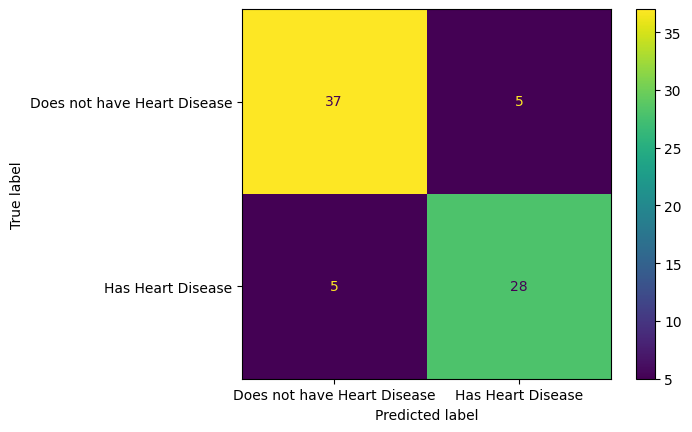

In [51]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Does not have Heart Disease", "Has Heart Disease"])
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

In the confusion matrix, we see that of the **37 + 5 = 42** people that did not have **Heart Disease**, **37 (88%)** were correctly classified. And of the **5 + 28 = 33** people that have **Heart Disease**, **28 (85%)** were correctly classified. So the support vector machine did pretty well without any optimization. That said, it is possible that we can improve predictions using **Cross Validation** to optimize the parameters.

----

<a id="optimize-svm"></a>
# Task 5: Optimize Parameters with Cross Validation

Optimizing a **Support Vector Machine** is all about finding the best value for **gamma**, and, potentially, the regularization parameter, **C**. So let's see if we can find better parameters using cross validation in hopes that we can improve the accuracy with the **Testing Dataset**.

Since we have to parameters two optimize, we will use `GridSearchCV()`. We do this by specifying potential values for **gamma** and **C**, and `GridSearchCV()` tests all possible combinations of the parameters for us.

In [38]:
param_grid=[
    {'C': [1,10,100,1000],
     'gamma': [0.001, 0.0001],
     'kernel': ['rbf']},
]
optimal_params = GridSearchCV(
    SVC(),
    param_grid,
    cv=5,
    verbose=0
)
optimal_params.fit(X_train_scaled, y_train)
optimal_params.best_params_

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

And we see that the ideal value for `C` is **10** and the ideal value for `gamma` is **0.001**.

----

<a id="draw-svm"></a>
# Task 6: Building & Evaluating the final model

Now that we have the ideal values for `C` and `gamma` we can build the final **Support Vector Machine**:

In [52]:
clf_svm=SVC(random_state=42, C=10, gamma=0.001)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=10, gamma=0.001, random_state=42)

Now let's draw another confusion matrix to see if the optimized support vector machine does better.

In [53]:
# Get predictions from the classifier
y_pred = clf_svm.predict(X_test_scaled)

In [54]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[38,  4],
       [ 4, 29]])

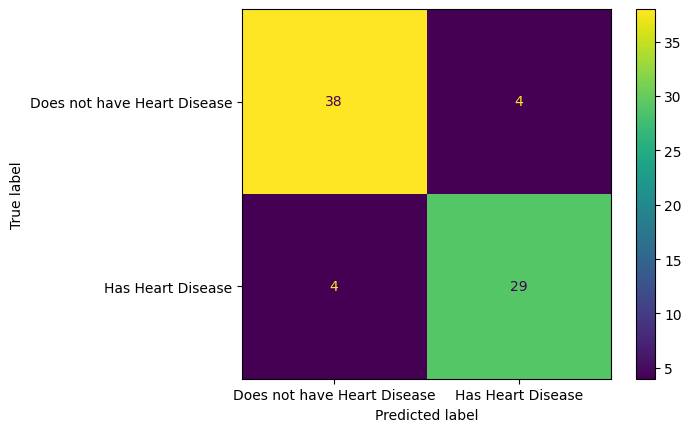

In [55]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Does not have Heart Disease", "Has Heart Disease"])
disp.plot()

# Show the plot
import matplotlib.pyplot as plt
plt.show()

We see that the optimized **Support Vector Machine** is better at classifying patients than the preliminary support vector machine.

Of the **38 + 4 = 42** people that did not have heart disease, **38 (90%)** were correctly classified. This is an improvement over the preliminary support vector machine, which only correctly classified **37 (88%)** of the patients without heart disease. Of the **4 + 29 = 33** people with heart disease, **29 (87%)** were correctly classified. This is also an improvement over the preliminary support vector machine, which only correctly classified **28 (85%)** of the patients with heart disease. Yay for optimizing the parameters!

----

<a id="draw-svm"></a>
# Task 7: Interpreting the Final Support Vector Machine

The last thing we are going to do is draw the optimized support vector machine decision boundary and discuss how to interpret it.

The first thing we need to do is count the number of columns in **X**:

In [46]:
len(df.columns)

14

So we see that there are **14** features, or columns, in **X**.
This is a problem because it would require a 14-dimensional graph, one dimension per feature used to make predictions, to plot the data in its raw form. If we wanted to, we could just pick two features at random to use as x and y-axes on our graph, but instead , we will use **PCA** (Principal Component Analysis) to combine the **14** features into **2** orthogonal meta-features that we can use as axes for a graph.

However, before we shrink the graph, let's first determine how accurate the shrunken graph will be. If it's relatively accurate, than it makes sense to draw the 2-Dimensional graph. If not, the shrunken graph will not be very useful. We can determine the accuracy of the graph by drawing something called a **scree plot**.

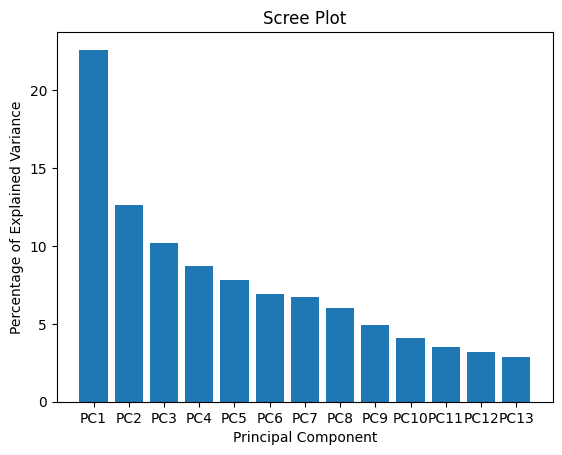

In [47]:
pca = PCA() # By default, PCA() centers the data, but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data, and this means that it will be a good candidate for the x-axis in the 2-dimensional graph. Since PC2 accounts for the next largest amount of variance, we will use that for the y-axis.

Now we will draw the PCA graph.

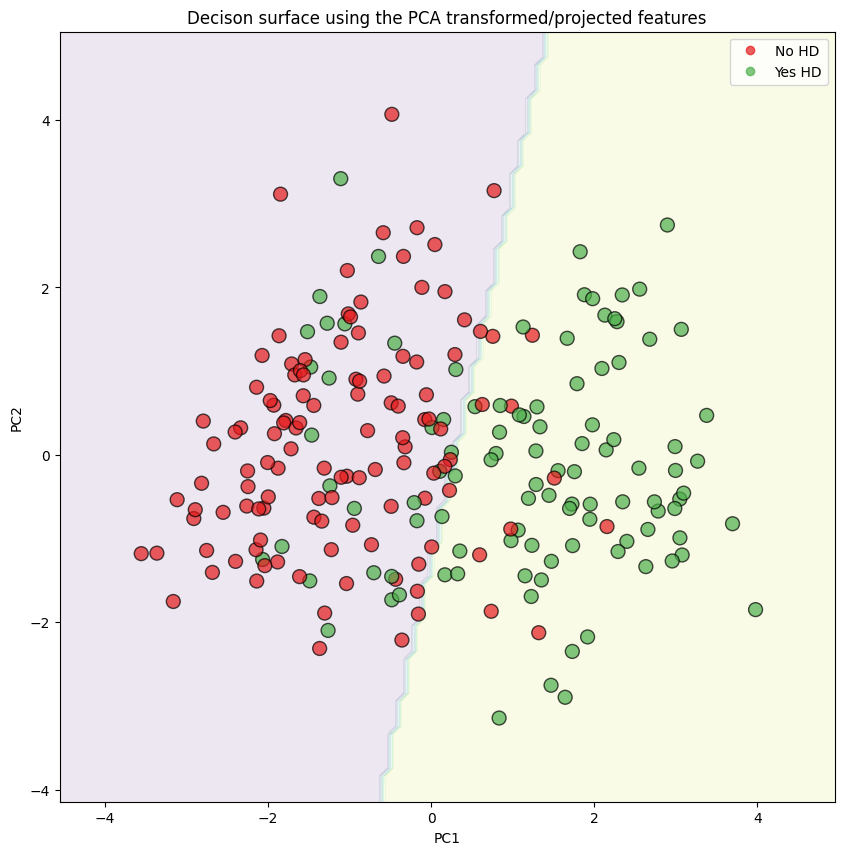

In [56]:
pc1 = X_train_pca[:, 0]
pc2 = X_train_pca[:, 1]

# NOTE:
# pc1 contains the x-axis coordinates of the data after PCA
# pc2 contains the y-axis coordinates of the data after PCA

# Now we fittthe SVM to the x and y-axis coordinates of the data after PCA dimension reduction
clf_svm.fit(np.column_stack((pc1, pc2)), y_train)

# Now create a matrix of points that we can use to show the decision regions.
# The matrix will be a little bit larger than the transformed PCA points
# so that we can plot all of the PCA points on it without them being on the edge
x_min = pc1.min() - 1
x_max = pc1.max() + 1

y_min = pc2.min() - 1
y_max = pc2.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

# Now we will classify every point in that # matrix with the SVM.
# Points on one side of the classification boundary will get 0, and points on the other side will get 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

# Right now, Z is just a long array of lots of 0s and 1s, which reflect how each point in the mesh was classified.
# We use reshape() so that each classification (0 or 1) corresponds to a specific point in the matrix.
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10,10))

# Now we will use contourf() to draw a filled contour plot using the matrix values and classifications.
# The contours will be filled according to the predicted classifications (0s and 1s) in Z
ax.contourf(xx, yy, Z, alpha=0.1)

# Now create custom colors for the actual data points
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

# Now darw the actual data points- these will be colored by their known (not predcited) classifications
# NOTE: setting alpha=0.7 lets us see if we are covering up a point
scatter = ax.scatter(pc1, pc2, c=y_train,
               cmap=cmap,
               s=100,
               edgecolors='k', ## 'k' = black
               alpha=0.7)

## Now create a legend
legend = ax.legend(scatter.legend_elements()[0],
                   scatter.legend_elements()[1],
                    loc="upper right")
legend.get_texts()[0].set_text("No HD")
legend.get_texts()[1].set_text("Yes HD")

# Now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decison surface using the PCA transformed/projected features')
# plt.savefig('svm.png')
plt.show()

The pink side of the graph on the left is the area were all datapoints will be predicted to *not have* heart disease. The yellow side of the graph on the right is the area where all datapoints will be predicted to *have* heart disease. The the dots are datapoints in the training dataset and are color coded by their known classifications: red is for those that did *not have* heart disease and green is for those that *did* have heart disease.